In [8]:
# analysis of the cloud predictor increment in VarBC
# examine how the cloud predictor changes when using BC TB vs noBC TB
# initial built: 2024/12/18
# revisit: 2025/04/21

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta


In [18]:
instrument = 'amsua'
channel    = 'ch1'
sdate      = '2022062000'
edate      = '2022081000'
date_short = sdate[4:8]+'_'+edate[4:8]

#exps       = ['full_ctrl','full_only_clr','full_clr_cld','full_model','full_obs','full_sym']
#exps = ['full_CTRL', 'full_only_clr','full_clr_cld']
exps = ['full_sym_tri', 'full_sym_clwnbc','full_sym_bc']
expstr = '-'.join(exps)
#cloud_predictor_name = ['Symmetric Cloud','Model Cloud', 'Obs Cloud']
cloud_predictor_name = ['Symmetric Cloud']

cloud_short = {'Symmetric Cloud':'sym', 'Model Cloud':'model', 'Obs Cloud':'obs'}


expshort = {'full_sym_tri'   : 'TENT_NOBC',
            'full_sym_clwnbc': 'POLY_NOBC',
            'full_sym_bc'    : 'POLY_BC'   }

'full_sym_tri-full_sym_clwnbc-full_sym_bc'

In [3]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

dic_ndata = {};
dic_c25 = {}; dic_c50 = {}; dic_c75 = {};
dic_t25 = {}; dic_t50 = {}; dic_t75 = {};

for exp in exps:
    
    print(f'now processing {exp}...')
    
    root_path = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/'
    fn = f'/{exp}/omf_stats_{instrument}_{channel}_{sdate}_{edate}.csv'
    tmpdf=pd.read_csv(f'{root_path}/{fn}')
    
    dic_ndata[exp]={};
    dic_c25[exp]={}; dic_c50[exp]={}; dic_c75[exp]={};
    dic_t25[exp]={}; dic_t50[exp]={}; dic_t75[exp]={};

    # dfs = data frame screend
    screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 )
    #screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 ) & ( tmpdf['varbc_idx_ges']==1 )
    dfs = tmpdf.loc[screen]
    dfs['clw_sym'] = 0.5*(dfs['clw_obs'] + dfs['clw_bg_nobc_ges']) # raw symmetric cloud

    x_cld = np.linspace(0,1,21)

    
    for cld_pred in cloud_predictor_name:
        
        print(f'     cloud predictor = {cld_pred}')
        
        ndata = np.zeros(len(x_cld)-1);
        cldinc_q25 = np.zeros(len(x_cld)-1);
        cldinc_q50 = np.zeros(len(x_cld)-1);
        cldinc_q75 = np.zeros(len(x_cld)-1);
        tbinc_q25  = np.zeros(len(x_cld)-1);
        tbinc_q50  = np.zeros(len(x_cld)-1);
        tbinc_q75  = np.zeros(len(x_cld)-1);

        for i in range(len(x_cld) - 1):
            
            if cld_pred == 'Obs Cloud':
                cld_screen = (dfs['clw_obs'] >= x_cld[i]) & (dfs['clw_obs'] < x_cld[i+1])
            elif cld_pred == 'Model Cloud':
                cld_screen = (dfs['clw_bg_nobc_ges'] >= x_cld[i]) & (dfs['clw_bg_nobc_ges'] < x_cld[i+1])
            elif cld_pred == 'Symmetric Cloud':
                cld_screen = (dfs['clw_sym'] >= x_cld[i]) & (dfs['clw_sym'] < x_cld[i+1])

            dfs_cld = dfs.loc[cld_screen]
            cld_inc = dfs_cld['clw_bg_ges'] - dfs_cld['clw_bg_nobc_ges']
            tb_inc  = dfs_cld['omfnbc_ges'] - dfs_cld['omf_ges']

            ndata[i]      = dfs_cld.shape[0]
            cldinc_q25[i] = cld_inc.quantile(0.25)
            cldinc_q50[i] = cld_inc.quantile(0.50)
            cldinc_q75[i] = cld_inc.quantile(0.75)
            tbinc_q25[i]  = tb_inc.quantile(0.25)
            tbinc_q50[i]  = tb_inc.quantile(0.50)
            tbinc_q75[i]  = tb_inc.quantile(0.75)
            
        dic_ndata[exp][cld_pred]=ndata
        dic_c25[exp][cld_pred]=cldinc_q25
        dic_c50[exp][cld_pred]=cldinc_q50
        dic_c75[exp][cld_pred]=cldinc_q75
        dic_t25[exp][cld_pred]=tbinc_q25 
        dic_t50[exp][cld_pred]=tbinc_q50 
        dic_t75[exp][cld_pred]=tbinc_q75

now processing full_sym_tri...
     cloud predictor = Symmetric Cloud
now processing full_sym_clwnbc...
     cloud predictor = Symmetric Cloud
now processing full_sym_bc...
     cloud predictor = Symmetric Cloud


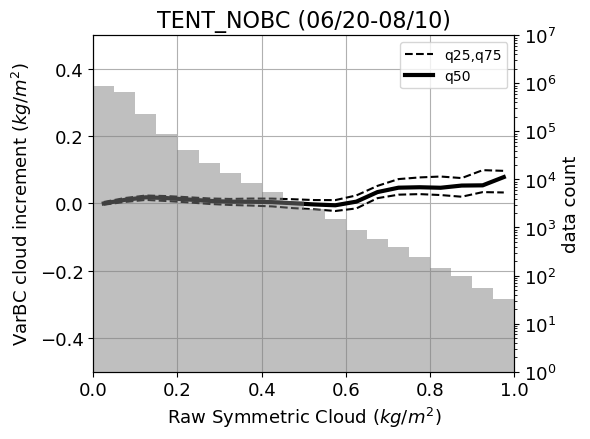

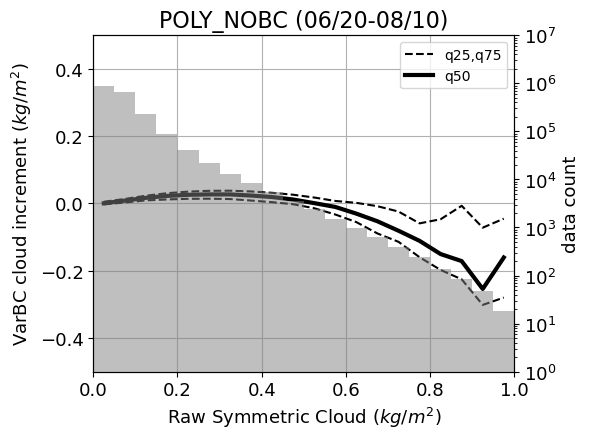

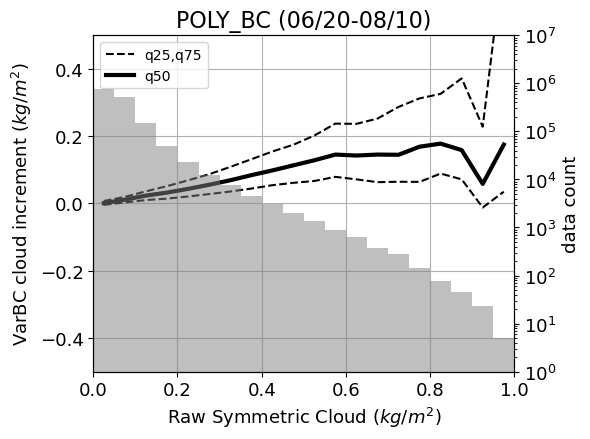

In [21]:
# Plot the cloud increment due to VarBC

save_fig = True
fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/varBC_and_omf_vs_cloud_analysis/{expstr}/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    

exp_list = exps
#exp_list = ['full_ctrl','full_clr_cld','full_only_clr']

#vmin = -0.8
#vmax =  0.8

vmin = -0.5
vmax =  0.5

for cld_pred in cloud_predictor_name:

    for exp in exp_list:
        fig, ax1 = plt.subplots(figsize=(6,4.5))
        x_axis = 0.5*(x_cld[:-1] + x_cld[1:])
        ax1.plot(x_axis, dic_c25[exp][cld_pred],label='q25,q75',color='black',linestyle='--')
        ax1.plot(x_axis, dic_c50[exp][cld_pred],label='q50',color='black',linewidth=3)
        ax1.plot(x_axis, dic_c75[exp][cld_pred],color='black',linestyle='--')
        ax1.grid(True)
        ax1.set_xlim(0,1)
        ax1.set_ylim(vmin,vmax)
        ax1.set_xlabel(rf'Raw {cld_pred} ($kg/m^2$)', fontsize=13)
        ax1.set_ylabel(r'VarBC cloud increment ($kg/m^2$)', fontsize=13)
        #ax1.legend(loc='upper left')
        ax1.legend()
        ax1.tick_params(axis='both', labelsize=13)

        ax2 = ax1.twinx()
        ax2.bar(x_axis, dic_ndata[exp][cld_pred], width=0.05, color=(0.5, 0.5, 0.5), alpha=0.5)
        ax2.set_yscale('log')
        ax2.set_ylim(1,1e7)
        ax2.set_ylabel('data count', fontsize=13)
        ax2.tick_params(axis='both', labelsize=13)
        ax2.set_title(f'{expshort[exp]} ({sdate[4:6]}/{sdate[6:8]}-{edate[4:6]}/{edate[6:8]})',fontsize=16)
        plt.tight_layout()

        if save_fig:
            plt.savefig(f"{fig_dir}/cloud_inc_timeavg_{cloud_short[cld_pred]}_{instrument}_{channel}_{date_short}_{exp}.png", dpi=300, bbox_inches='tight')

        plt.show()

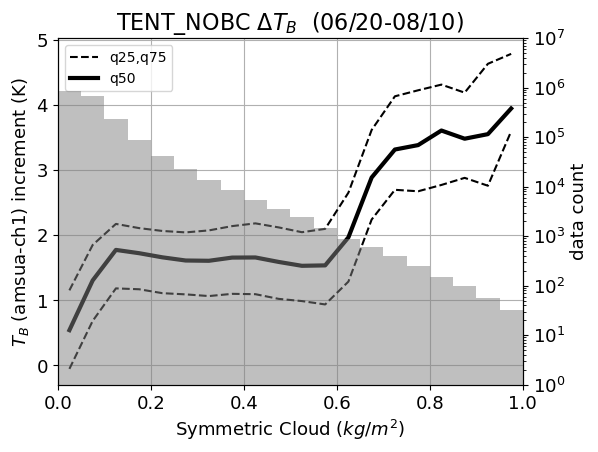

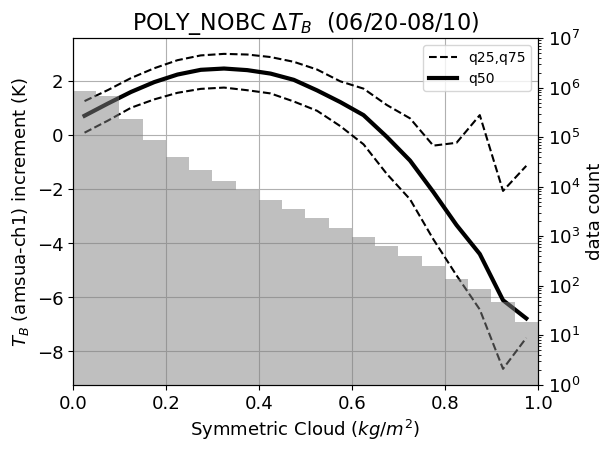

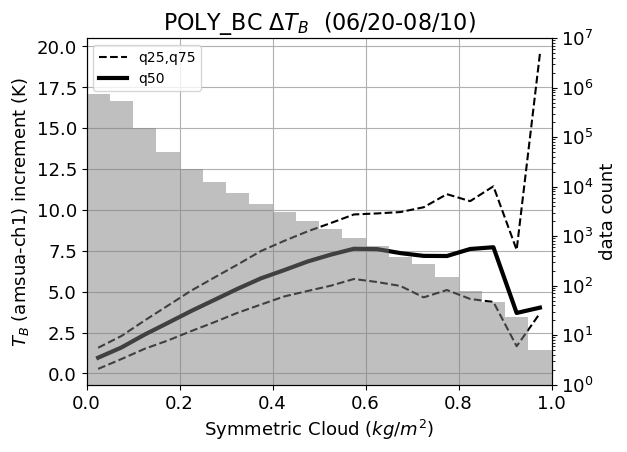

In [23]:
# Plot the TB increment due to VarBC

save_fig = True
fig_dir = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/python_codes/figures/varBC_and_omf_vs_cloud_analysis/{expstr}/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")
    

for cld_pred in cloud_predictor_name:

    for exp in exps:
        fig, ax1 = plt.subplots(figsize=(6,4.5))
        x_axis = 0.5*(x_cld[:-1] + x_cld[1:])
        ax1.plot(x_axis, dic_t25[exp][cld_pred],label='q25,q75',color='black',linestyle='--')
        ax1.plot(x_axis, dic_t50[exp][cld_pred],label='q50',color='black',linewidth=3)
        ax1.plot(x_axis, dic_t75[exp][cld_pred],color='black',linestyle='--')
        ax1.grid(True)
        ax1.set_xlim(0,1)
        ax1.set_xlabel(rf'{cld_pred} ($kg/m^2$)', fontsize=13)
        ax1.set_ylabel(rf'$T_B$ ({instrument}-{channel}) increment (K)', fontsize=13)
        #ax1.legend(loc='upper left')
        ax1.legend()
        ax1.tick_params(axis='both', labelsize=13)

        ax2 = ax1.twinx()
        ax2.bar(x_axis, dic_ndata[exp][cld_pred], width=0.05, color=(0.5, 0.5, 0.5), alpha=0.5)
        ax2.set_yscale('log')
        ax2.set_ylim(1,1e7)
        ax2.set_ylabel('data count', fontsize=13)
        ax2.tick_params(axis='both', labelsize=13)
        ax2.set_title(rf'{expshort[exp]} $\Delta T_B$  ({sdate[4:6]}/{sdate[6:8]}-{edate[4:6]}/{edate[6:8]})',fontsize=16)
        
        if save_fig:
            plt.savefig(f"{fig_dir}/TB_inc_timeavg_{cloud_short[cld_pred]}_{instrument}_{channel}_{date_short}_{exp}.png", dpi=300, bbox_inches='tight')
        plt.plot()

In [33]:
cld_screen = (dfs['clw_obs'] >= 0.3)
dfs_cld = dfs.loc[cld_screen]
cloud_inc = dfs_cld['clw_bg_ges'] - dfs_cld['clw_bg_nobc_ges']

In [35]:
cloud_inc.quantile(0.25)

0.26755197000000003

In [32]:
dfs_cld

,sensor,lat,lon,fwater,fland,obs,clw_obs,clw_bg_ges,clw_bg_nobc_ges,symerr_ges,...,omf_ges,omfnbc_ges,varbc_idx_ges,clw_bg_anl,clw_bg_nobc_anl,symerr_anl,errinv_anl,omf_anl,omfnbc_anl,varbc_idx_anl
15,n18,-55.2975,359.0754,1.0,0.0,167.54,0.341823,0.503690,0.258828,7.5,...,-5.203506,6.243232,0.0,0.497656,0.251969,7.5,0.048730,-5.022662,6.620156,0.0
16,n18,-54.0189,1.0074,1.0,0.0,161.89,0.335360,0.593691,0.205068,7.5,...,-8.942612,8.511243,0.0,0.604274,0.210219,7.5,0.032261,-9.833190,7.940853,0.0
61,n18,-49.0289,27.1135,1.0,0.0,165.29,0.331367,0.662030,0.337109,7.5,...,-12.873236,1.333661,0.0,0.666342,0.338164,7.5,0.032789,-13.079727,1.345012,0.0
74,n18,-47.6686,26.4722,1.0,0.0,166.83,0.324884,0.671133,0.318630,7.5,...,-13.437336,1.838910,0.0,0.641997,0.292787,7.5,0.032868,-12.149055,3.370656,0.0
85,n18,-46.2044,23.7503,1.0,0.0,174.39,0.444541,0.854425,0.340743,7.5,...,-13.281785,6.990838,0.0,0.868260,0.347676,7.5,0.032393,-14.346238,6.299960,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21367,n19,-35.8146,346.2682,1.0,0.0,195.98,0.433281,0.725487,0.250562,7.5,...,-11.406477,8.612502,0.0,0.683643,0.215014,7.5,0.035662,-9.341453,10.516938,0.0
21397,n19,-31.7698,339.1938,1.0,0.0,198.02,0.407624,0.660134,0.225333,7.5,...,-10.066505,8.906190,0.0,0.593246,0.168955,7.5,0.045390,-6.415238,12.413877,0.0
21408,n19,-30.4679,338.2571,1.0,0.0,197.34,0.333983,0.484710,0.184753,7.5,...,-6.834915,7.917915,0.0,0.424012,0.128571,7.5,0.074405,-2.573732,12.072419,0.0
21420,n19,-29.2635,339.6540,1.0,0.0,195.18,0.416636,0.488179,0.075758,7.5,...,-1.785148,17.598194,0.0,0.484064,0.071189,7.5,0.088145,-1.440383,17.799250,0.0


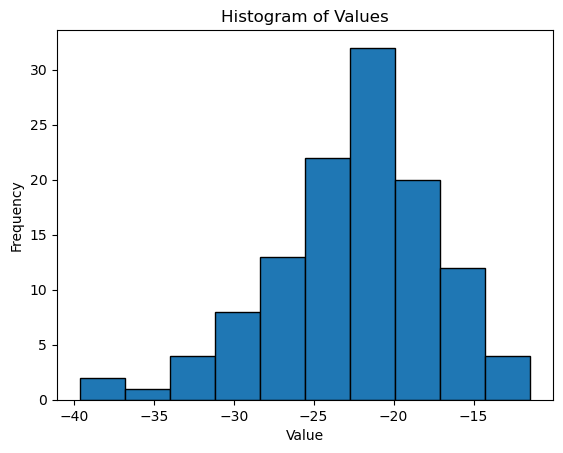

In [12]:
plt.hist(dfs_cld['omf_ges']-dfs_cld['omfnbc_ges'], bins=10, edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [25]:
df={};
ct_clr_nobc={}; ct_clr_bc={}; ct_cld_nobc={}; ct_cld_bc={}; ct_mis_nobc={}; ct_mis_bc={};
ct_clr_clddiff={}; ct_cld_clddiff={};

for exp in exps:
    print(f'processing {exp}')
    current_time = init_time
    
    ct_clr_nobc[exp] = 0
    ct_clr_bc  [exp] = 0
    ct_cld_nobc[exp] = 0
    ct_cld_bc  [exp] = 0
    ct_mis_nobc[exp] = 0
    ct_mis_bc  [exp] = 0
    ct_clr_clddiff[exp] = 0
    ct_cld_clddiff[exp] = 0
    
    while current_time <= final_time:
        format_time  = current_time.strftime("%Y%m%d%H")
        
        if (current_time.hour == 0) & (np.mod(current_time.day,5)== 0):
            print(f'time = {format_time}')
        
        fn = f'/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/compile_radstats/csv_files/{exp}/each_cycle/{format_time}/omf_stats_{instrument}_{channel}_{format_time}.csv'
        tmpdf=pd.read_csv(fn)
        
        # dfs = data frame screend
        screen = (tmpdf['fwater'] > 0.99) & (tmpdf['fland'] < 0.01) & ( tmpdf['errinv_ges'] >0 )
        dfs = tmpdf.loc[screen]

        # clr/clr and cld/cld definition
        cld_cri = 0.03
        clr_def = (dfs['clw_obs'] <= cld_cri) & (dfs['clw_bg_ges'] <= cld_cri)
        cld_def = (dfs['clw_obs']  > cld_cri) & (dfs['clw_bg_ges']  > cld_cri)
        mis_def = (dfs['clw_obs'] <= cld_cri) & (dfs['clw_bg_ges']  > cld_cri) | \
                  (dfs['clw_obs']  > cld_cri) & (dfs['clw_bg_ges'] <= cld_cri)

        df_clr = dfs.loc[clr_def]
        df_cld = dfs.loc[cld_def]
        df_mis = dfs.loc[mis_def]
        
        if norm_by == 'final_error':
            # normalized by the final obs error:
            omf_clr_nobc = plt_sign*df_clr['omfnbc_ges'].values * df_clr['errinv_ges'].values
            omf_clr_bc   = plt_sign*df_clr['omf_ges'].values    * df_clr['errinv_ges'].values
            omf_cld_nobc = plt_sign*df_cld['omfnbc_ges'].values * df_cld['errinv_ges'].values
            omf_cld_bc   = plt_sign*df_cld['omf_ges'].values    * df_cld['errinv_ges'].values
            omf_mis_nobc = plt_sign*df_mis['omfnbc_ges'].values * df_mis['errinv_ges'].values
            omf_mis_bc   = plt_sign*df_mis['omf_ges'].values    * df_mis['errinv_ges'].values
        
        elif norm_by == 'sym_error':
            ## normalized by the symmetric cloud
            omf_clr_nobc = plt_sign*df_clr['omfnbc_ges'].values / df_clr['symerr_ges'].values
            omf_clr_bc   = plt_sign*df_clr['omf_ges'].values    / df_clr['symerr_ges'].values
            omf_cld_nobc = plt_sign*df_cld['omfnbc_ges'].values / df_cld['symerr_ges'].values
            omf_cld_bc   = plt_sign*df_cld['omf_ges'].values    / df_cld['symerr_ges'].values
            omf_mis_nobc = plt_sign*df_mis['omfnbc_ges'].values / df_mis['symerr_ges'].values
            omf_mis_bc   = plt_sign*df_mis['omf_ges'].values    / df_mis['symerr_ges'].values        
        
        # define the bin_edges for the histogram
        dx = 0.05
        bin_max = 6
        
        bins = np.arange(-bin_max, bin_max+dx, dx)
        
        counts, _ = np.histogram(omf_clr_nobc, bins=bins)
        ct_clr_nobc[exp] += counts

        counts, _ = np.histogram(omf_clr_bc, bins=bins)
        ct_clr_bc  [exp] += counts
        
        counts, _ = np.histogram(omf_cld_nobc, bins=bins)
        ct_cld_nobc[exp] += counts
        
        counts, _ = np.histogram(omf_cld_bc, bins=bins)
        ct_cld_bc  [exp] += counts
        
        dx = 0.1
        bin_max = 6
        
        bins_mis = np.arange(-bin_max, bin_max+dx, dx)
        
        counts, _ = np.histogram(omf_mis_nobc, bins=bins_mis)
        ct_mis_nobc[exp] += counts
        
        counts, _ = np.histogram(omf_mis_bc, bins=bins_mis)
        ct_mis_bc  [exp] += counts
        
        ## calculate the cloud differnce:
        '''
        clr_clddiff = df_clr['clw_obs'] - df_clr['clw_bg_ges']
        cld_clddiff = df_cld['clw_obs'] - df_cld['clw_bg_ges']
        
        # define the bin_edges for the histogram
        dx = 0.005
        bin_max = 0.5
        
        bins = np.arange(-bin_max, bin_max+dx, dx)
        bin_center = 0.5*(bins[:-1] + bins[1:])
        
        counts, _ = np.histogram(clr_clddiff, bins=bins)
        ct_clr_clddiff[exp] += counts

        counts, _ = np.histogram(cld_clddiff, bins=bins)
        ct_cld_clddiff[exp] += counts     
        '''
        
        # progress to the next time step
        current_time = current_time + timedelta(hours=dt)

processing ctrl
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000
processing ctrl_noinf
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000
processing only_clr_clr
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000
processing only_clr_clr_noinf
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000
processing clr_and_cld_0.05
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500
time = 2022072000
processing clr_and_cld_0.05_noinf
time = 2022061500
time = 2022062000
time = 2022062500
time = 2022063000
time = 2022070500
time = 2022071000
time = 2022071500


In [26]:
# estimate the mean & mode of each pdfs:
mean_clr_bc={}; mean_clr_nobc={}; mean_cld_bc={}; mean_cld_nobc={}; mean_mis_nobc={}; mean_mis_bc={};
mode_clr_bc={}; mode_clr_nobc={}; mode_cld_bc={}; mode_cld_nobc={};

dx = 0.05
bin_max = 6

bins = np.arange(-bin_max, bin_max+dx, dx)
bin_center = 0.5*(bins[:-1] + bins[1:])

dx = 0.1
bin_max = 6

bins_mis = np.arange(-bin_max, bin_max+dx, dx)
bin_center_mis = 0.5*(bins_mis[:-1] + bins_mis[1:])

for exp in exps:
    mean_clr_bc[exp]   = sum(ct_clr_bc[exp]  *bin_center/sum(ct_clr_bc[exp]  ))
    mean_clr_nobc[exp] = sum(ct_clr_nobc[exp]*bin_center/sum(ct_clr_nobc[exp]))
    mean_cld_bc[exp]   = sum(ct_cld_bc[exp]  *bin_center/sum(ct_cld_bc[exp]  ))
    mean_cld_nobc[exp] = sum(ct_cld_nobc[exp]*bin_center/sum(ct_cld_nobc[exp]))
    mean_mis_bc[exp]   = sum(ct_mis_bc[exp]  *bin_center_mis/sum(ct_mis_bc[exp]  ))
    mean_mis_nobc[exp] = sum(ct_mis_nobc[exp]*bin_center_mis/sum(ct_mis_nobc[exp]))
    
    '''
    mode_clr_bc[exp]   = bin_center[np.where(ct_clr_bc[exp]   == max(ct_clr_bc[exp]))  ]
    mode_clr_nobc[exp] = bin_center[np.where(ct_clr_nobc[exp] == max(ct_clr_nobc[exp]))]
    mode_cld_bc[exp]   = bin_center[np.where(ct_cld_bc[exp]   == max(ct_cld_bc[exp]))  ]
    mode_cld_nobc[exp] = bin_center[np.where(ct_cld_nobc[exp] == max(ct_cld_nobc[exp]))]
    '''

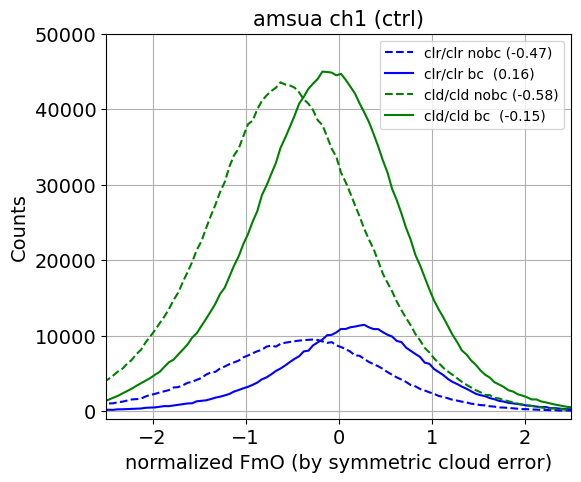

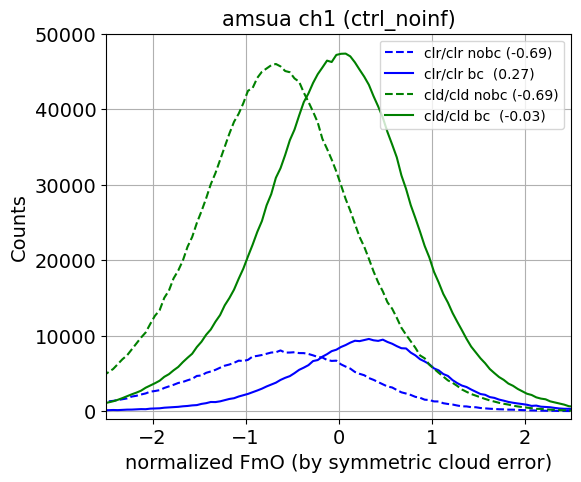

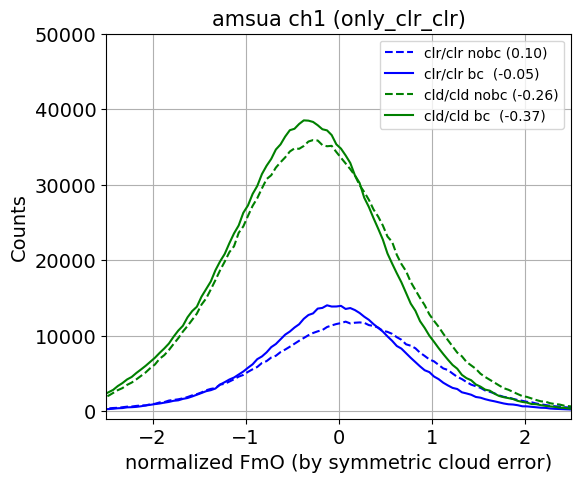

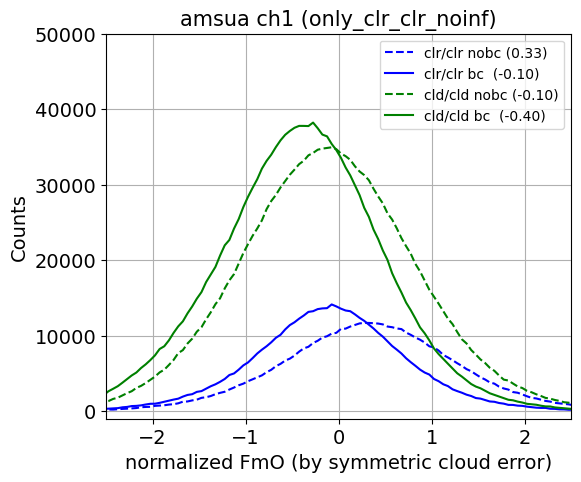

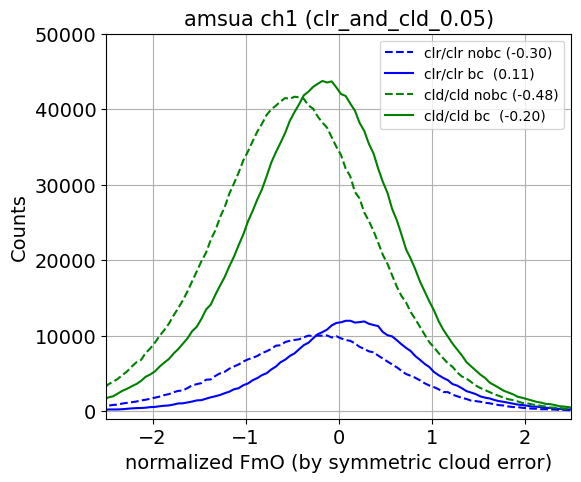

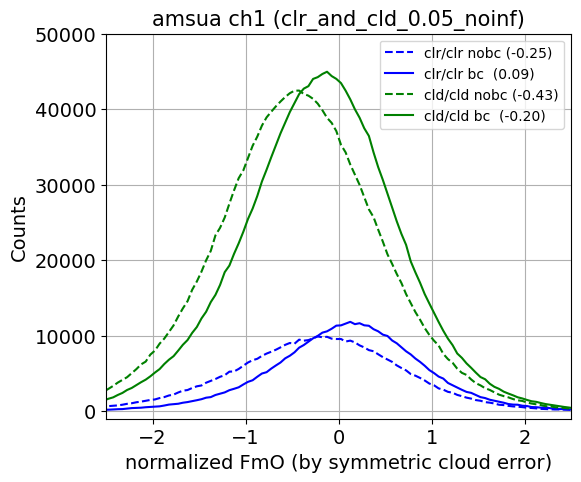

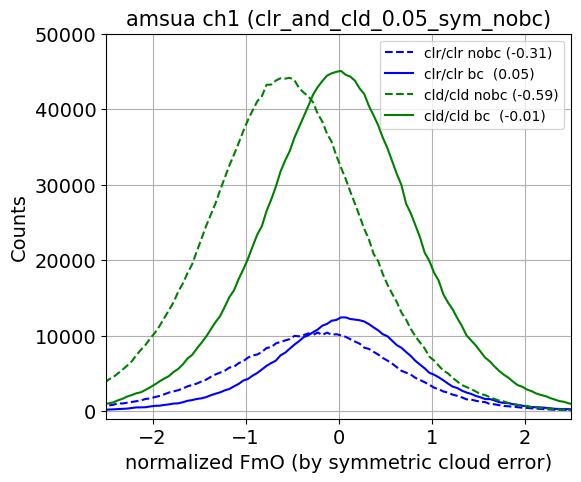

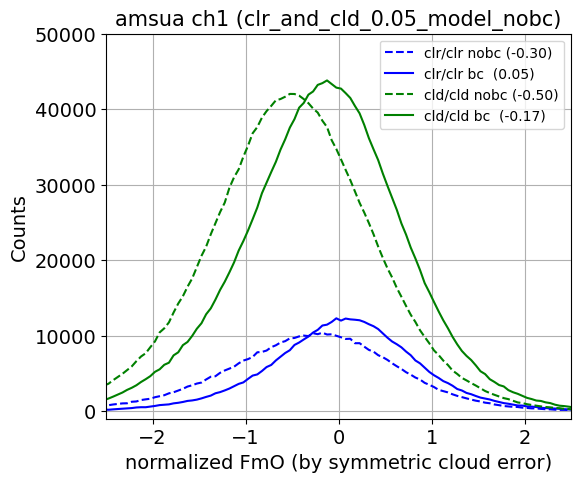

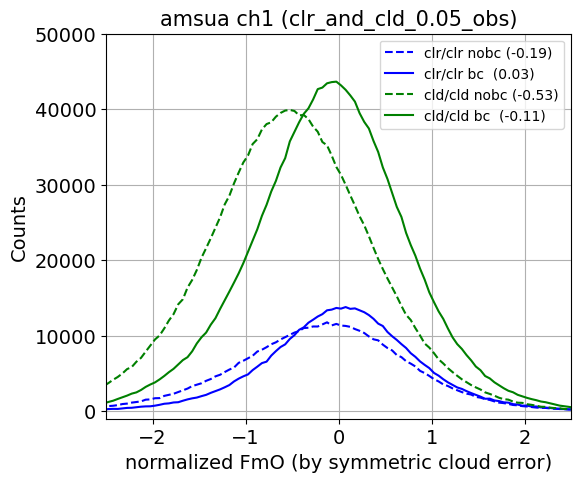

In [33]:
# Plot the clr/clr and cld/cld omf distribution

dx = 0.05
bin_max = 6

bins = np.arange(-bin_max, bin_max+dx, dx)
bin_center = 0.5*(bins[:-1] + bins[1:])

for exp in exps:
    #exptest = 'ctrl_noinf'
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(bin_center, ct_clr_nobc[exp],linestyle='--' ,color='blue',  label=f'clr/clr nobc ({mean_clr_nobc[exp]:.2f})')
    ax.plot(bin_center, ct_clr_bc[exp],  linestyle='-'  ,color='blue',  label=f'clr/clr bc  ({mean_clr_bc[exp]:.2f})')
    ax.plot(bin_center, ct_cld_nobc[exp],linestyle='--' ,color='green', label=f'cld/cld nobc ({mean_cld_nobc[exp]:.2f})')
    ax.plot(bin_center, ct_cld_bc[exp],  linestyle='-'  ,color='green', label=f'cld/cld bc  ({mean_cld_bc[exp]:.2f})')
    ax.legend()
    if channel in ('ch4','ch5','ch6'):
        ax.set_xlim(-6,4)
    else:
        #ax.set_xlim(-4,4)
        ax.set_xlim(-2.5,2.5)
    
    if norm_by == 'final_error':
        if omf_or_fmo == 'omf':
            ax.set_xlabel('normalized OmF (by final error)',fontsize=14)
        else:
            ax.set_xlabel('normalized FmO (by final error)',fontsize=14)
    elif norm_by == 'sym_error':
        if omf_or_fmo == 'omf':
            ax.set_xlabel('normalized OmF (by symmetric cloud error)',fontsize=14)
        else:
            ax.set_xlabel('normalized FmO (by symmetric cloud error)',fontsize=14)

    ax.set_ylabel('Counts',fontsize=14)
    ax.set_ylim(-1000, 50000)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'{instrument} {channel} ({exp})', fontsize=15)
    ax.grid(True)
    plt.savefig(f'clr_clr_cld_cld_{omf_or_fmo}_normby_{norm_by}_{instrument}_{channel}_{exp}.png', dpi=200, bbox_inches='tight')    

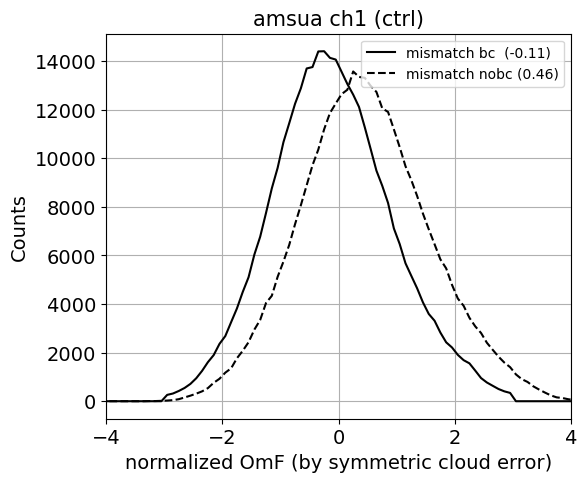

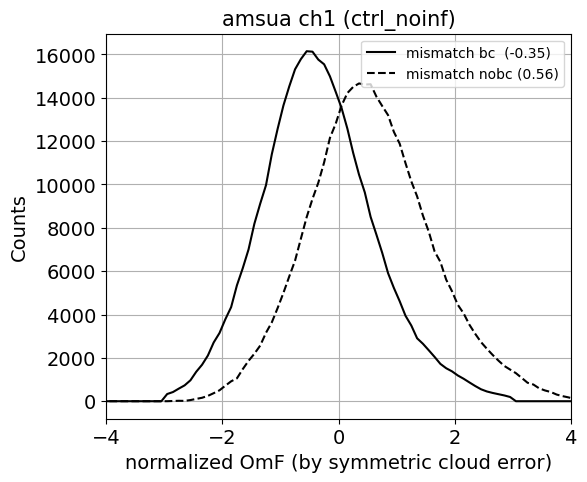

In [137]:
# Plot cloud mismatch
# Plot the clr/clr and cld/cld omf distribution

dx = 0.1
bin_max = 6

bins_mis = np.arange(-bin_max, bin_max+dx, dx)
bin_center_mis = 0.5*(bins_mis[:-1] + bins_mis[1:])

for exp in exps:
    #exptest = 'ctrl_noinf'
    fig, ax = plt.subplots(figsize=(6,5))
    ax.plot(bin_center_mis, ct_mis_bc[exp],  linestyle='-'  ,color='black', label=f'mismatch bc  ({mean_mis_bc[exp]:.2f})')
    ax.plot(bin_center_mis, ct_mis_nobc[exp],linestyle='--' ,color='black', label=f'mismatch nobc ({mean_mis_nobc[exp]:.2f})')
    ax.legend(loc='upper right')
    if channel in ('ch4','ch5','ch6'):
        ax.set_xlim(-6,4)
    else:
        ax.set_xlim(-4,4)
    
    if norm_by == 'final_error':
        if omf_or_fmo == 'omf':
            ax.set_xlabel('normalized OmF (by final error)',fontsize=14)
        else:
            ax.set_xlabel('normalized FmO (by final error)',fontsize=14)
    elif norm_by == 'sym_error':
        if omf_or_fmo == 'omf':
            ax.set_xlabel('normalized OmF (by symmetric cloud error)',fontsize=14)
        else:
            ax.set_xlabel('normalized FmO (by symmetric cloud error)',fontsize=14)

    ax.set_ylabel('Counts',fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_title(f'{instrument} {channel} ({exp})', fontsize=15)
    ax.grid(True)
    #plt.savefig(f'clr_clr_cld_cld_{omf_or_fmo}_normby_{norm_by}_{instrument}_{channel}_{exp}.png', dpi=200, bbox_inches='tight')    



In [103]:
dfs[mis_def][['clw_obs', 'clw_bg_ges','omf_ges','omfnbc_ges']]

,clw_obs,clw_bg_ges,omf_ges,omfnbc_ges
116,0.043440,0.020935,-1.873120,1.421153
126,0.035544,0.026006,-2.219060,1.274239
148,0.043592,0.022999,-2.051647,1.570641
149,0.031630,0.015221,-1.372539,1.837820
160,0.027242,0.042059,-2.753912,0.498367
...,...,...,...,...
21862,0.084445,0.018263,-3.509634,-2.027049
21878,0.026676,0.081343,-5.310584,-3.164992
21880,0.015854,0.035483,-1.725145,0.703739
21888,0.017086,0.031702,1.007887,3.381280


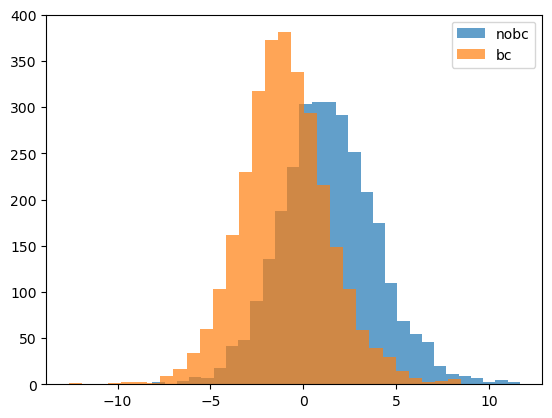

In [108]:
plt.hist(dfs[mis_def]['omfnbc_ges'], bins=30, alpha=0.7, label='nobc')
plt.hist(dfs[mis_def]['omf_ges'], bins=30, alpha=0.7, label='bc')
plt.legend()